In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read result's summaries
cal = np.load(f"../results/summary_calibration.npy", allow_pickle=True).item()
val = np.load(f"../results/summary_validation.npy", allow_pickle=True).item()

In [3]:
selected_basins = ['02055100', '02143000',
                   '12143600', '11381500',
                   '03500000', '14306500'
                  ]

In [4]:
basin_names = {'02055100': "Tinker Creek", 
               '02143000': "Henry Fork",
               '12143600': "Little Tennessee", 
               '11381500': "Mill Creek",
               '03500000': "Alsea River", 
               '14306500': "Snoqualmie River"}

In [5]:
# helper functions for easier data extraction from result files
def converter(results_instance, basin, model_name, metric_name):
    cdl = [1, 2, 3, 5, 7, 10, 14]
    return [list(results_instance[basin][model_name][dur][metric_name].values()) for dur in cdl]

def converted_agg(results_instance, basin, model_name, metric_name, numpy_function):
    cdl = [1, 2, 3, 5, 7, 10, 14]
    return [numpy_function(list(results_instance[basin][model_name][dur][metric_name].values())) for dur in cdl]

In [6]:
def eff_vs_duration(basin, model, color, ax=None, fontsize=16, metric="NSE"):
    
    cdl = [1, 2, 3, 5, 7, 10, 14]
    
    data = converter(val, basin, model, metric)
    
    df = pd.DataFrame({key:np.append(data[cdl.index(key)], np.repeat(np.nan, key-1)) for key in cdl})
    
    
    m = [np.nanmean(data[cdl.index(key)]) for key in cdl]
    
    m_min = [np.nanmin(data[cdl.index(key)]) for key in cdl]
    m_max = [np.nanmax(data[cdl.index(key)]) for key in cdl]
    
    ax.fill_between(cdl, m_min, m_max, color=color, alpha=0.4, zorder=0)
    
    for key, value in df.items():
        ax.plot(np.ones(len(value))*key, value, marker='o', markersize=7, linestyle='None', 
                 markerfacecolor='None', markeredgecolor='gray', markeredgewidth=1, zorder=1)
    
    
    ax.plot(cdl, m, c=color, linestyle="-", linewidth=3, zorder=2)
    
    
    ax.set_xticks(cdl)
    ax.set_xticklabels(cdl, fontsize=fontsize)
    ax.set_yticks(np.arange(0.,1.0,0.2))
    ax.set_yticklabels(np.round(np.arange(0.,1.0,0.2),1), fontsize=fontsize)

    ax.set_ylim(0., 0.95)
    ax.set_xlim(0, 15)
    
    ax.text(9, 0.15, model, fontsize=fontsize+4, weight="bold")
    
    ax.text(7, 0.05, "{} ({}) / {}".format(np.round(np.max(m),2),
                                          cdl[np.argmax(m)],
                                          np.round(m[0],2)), fontsize=fontsize+2, style="italic")
    
    ax.set_title(f"{basin}: {basin_names[basin]}", fontsize=fontsize+4)
    
    ax.grid(linestyle="--", linewidth=0.5)

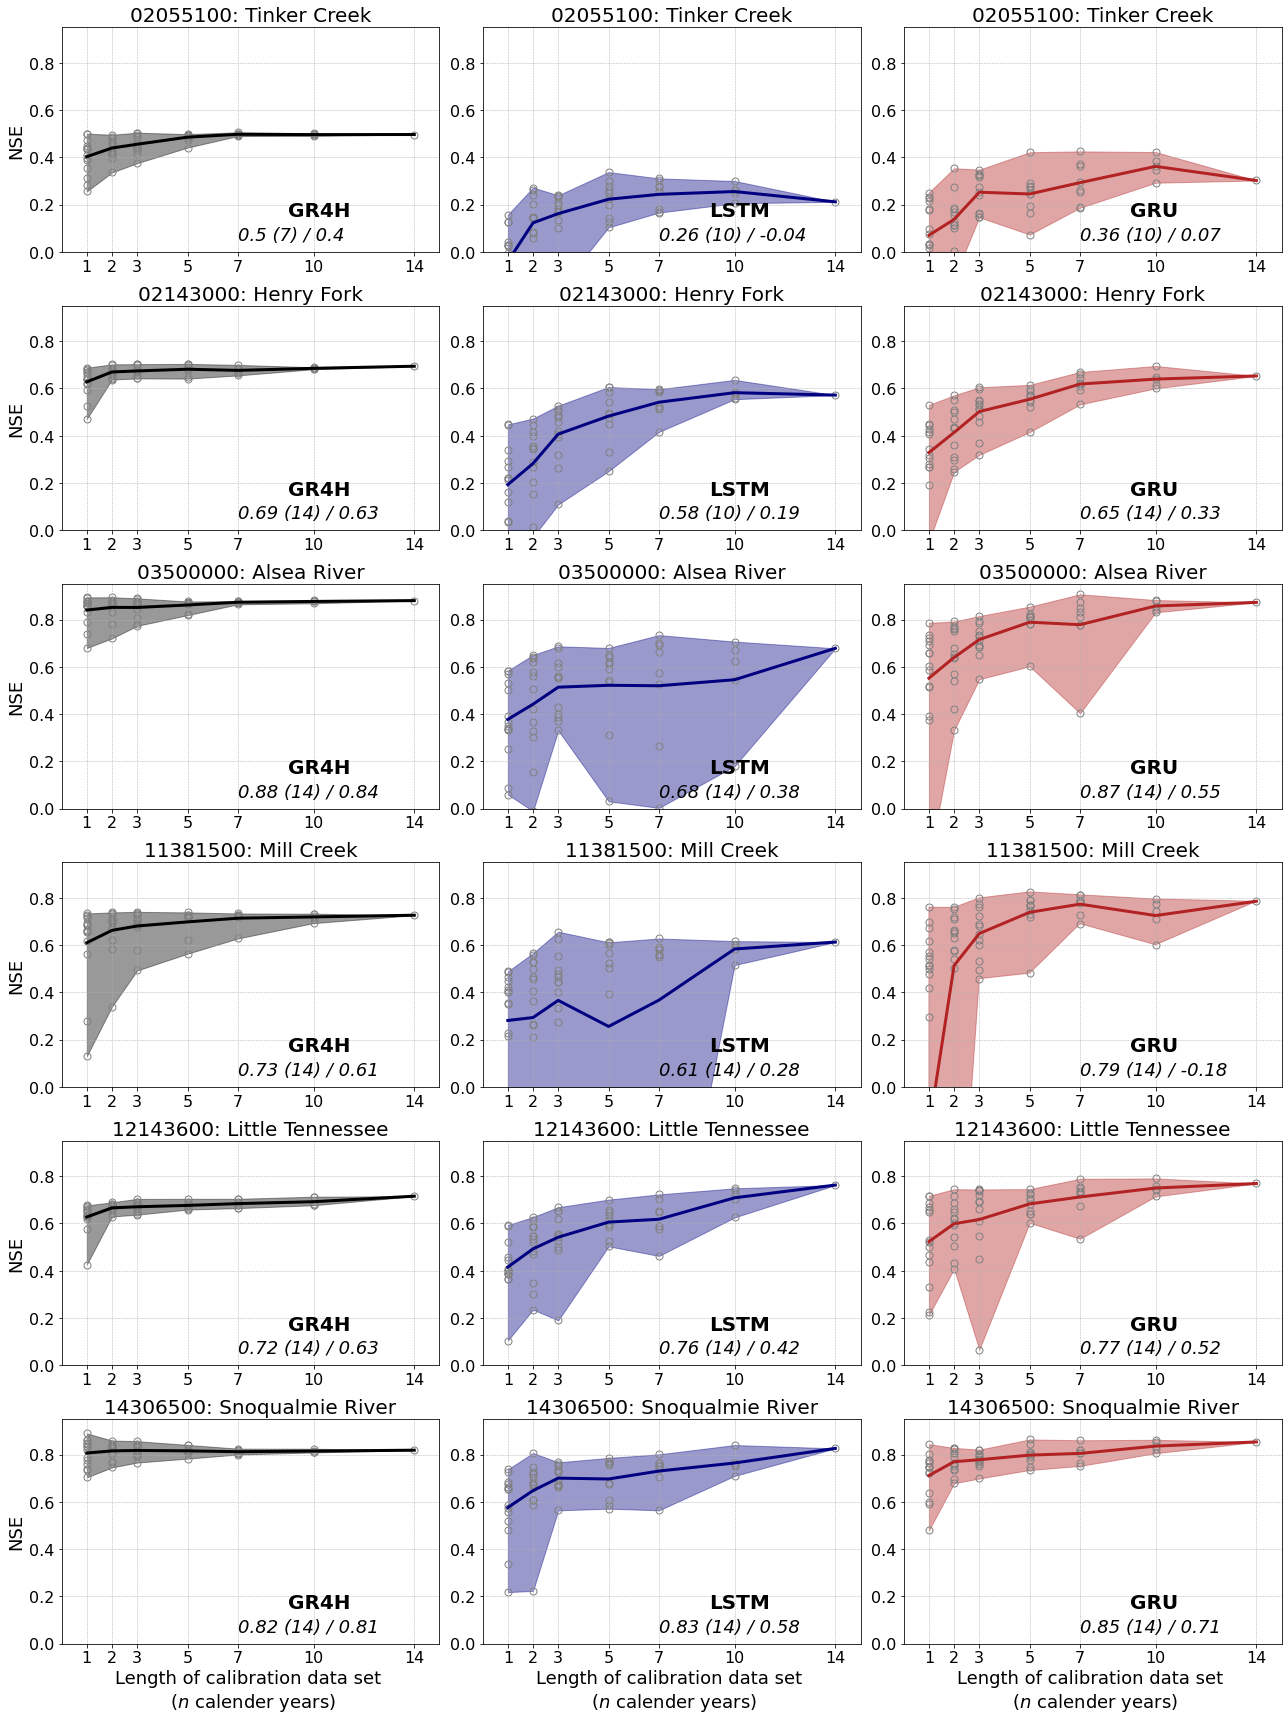

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18,24))

color_dict = {"LSTM": "navy", "GRU": "firebrick", "GR4H": "black"}

for i, basin in enumerate(sorted(selected_basins)):
    for j, model in enumerate(["GR4H", "LSTM", "GRU"]):
    
        eff_vs_duration(basin, model, color_dict[model], axes[i,j], fontsize=16, metric="NSE")

for i in range(6):
    axes[i,0].set_ylabel("NSE", fontsize=18)

for j in range(3): 
    axes[-1,j].set_xlabel("Length of calibration data set \n ("+r"$n$ " +"calender years)", fontsize=18)
        
fig.tight_layout()

In [8]:
fig.savefig("../figures/NSE_vs_length.png", dpi=300, bbox_inches="tight")

In [9]:
def loss_vs_duration(basin, model, color, order, ax=None, fontsize=16, metric="NSE"):
    
    cdl = [1, 2, 3, 5, 7, 10, 14]
    
    c = converted_agg(cal, basin, model, metric, np.mean)
    v = converted_agg(val, basin, model, metric, np.mean)
    
    loss = (np.array(c)-np.array(v))/np.abs(np.array(c))*100
    
    ax.plot(cdl, loss, 
            c=color, 
            label=model, 
            linestyle="-", linewidth=3, zorder=order)
    
    ax.set_title(f"{basin}: {basin_names[basin]}", fontsize=fontsize+4)
    ax.legend(loc=1, fontsize=fontsize, framealpha=1.)
    ax.grid(linestyle="--", linewidth=0.5)
    
    ax.set_xticks(cdl)
    ax.set_xticklabels(cdl, fontsize=fontsize)
    ax.set_yticks(np.arange(-20,110,20))
    ax.set_yticklabels(range(-20,110,20), fontsize=fontsize)

    ax.set_ylim(-20, 100)
    ax.set_xlim(0, 15)

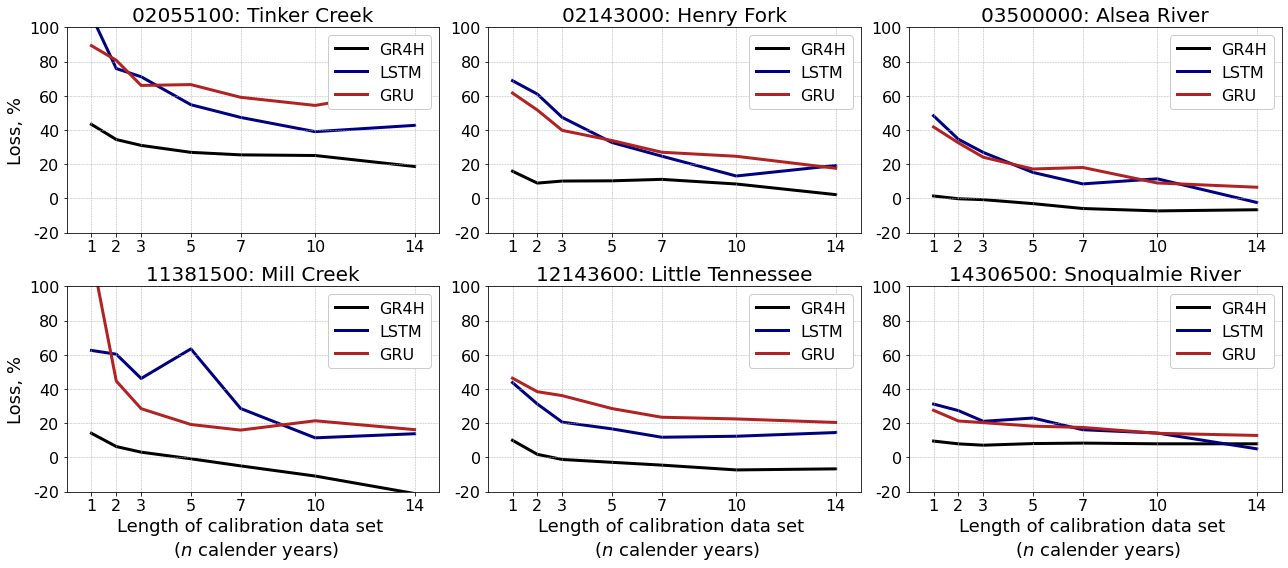

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

axes = axes.ravel()

for i, basin in enumerate(sorted(selected_basins)):
    for j, model in enumerate(["GR4H", "LSTM", "GRU"]):
    
        loss_vs_duration(basin, model, color_dict[model], j, axes[i], fontsize=16, metric="NSE")

axes = axes.reshape(2,3)

for i in range(2):
    axes[i,0].set_ylabel("Loss, %", fontsize=18)

for j in range(3): 
    axes[-1,j].set_xlabel("Length of calibration data set \n ("+r"$n$ " +"calender years)", fontsize=18)
        
fig.tight_layout()

In [11]:
fig.savefig("../figures/NSE_loss_vs_length.png", dpi=300, bbox_inches="tight")